In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fuels-futures-data/all_fuels_data.csv
/kaggle/input/fuels-futures-data/individual_data/RBOB_Gasoline_data.csv
/kaggle/input/fuels-futures-data/individual_data/Heating_Oil_data.csv
/kaggle/input/fuels-futures-data/individual_data/Brent_Crude_Oil_data.csv
/kaggle/input/fuels-futures-data/individual_data/Crude_Oil_data.csv
/kaggle/input/fuels-futures-data/individual_data/Natural_Gas_data.csv


# **Gasoline's Price Forecasting using Machine Learning (XGBoost)**

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('/kaggle/input/fuels-futures-data/all_fuels_data.csv')
df.head()

,ticker,commodity,date,open,high,low,close,volume
0,CL=F,Crude Oil,2000-08-23,31.950001,32.799999,31.950001,32.049999,79385
1,CL=F,Crude Oil,2000-08-24,31.900000,32.240002,31.400000,31.629999,72978
2,CL=F,Crude Oil,2000-08-25,31.700001,32.099998,31.320000,32.049999,44601
3,CL=F,Crude Oil,2000-08-28,32.040001,32.919998,31.860001,32.869999,46770
4,CL=F,Crude Oil,2000-08-29,32.820000,33.029999,32.560001,32.720001,49131


# Exploratory Data Analysis

In [4]:
#Change 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [5]:
df['commodity'].value_counts()

commodity
Crude Oil          5840
Natural Gas        5836
Heating Oil        5833
RBOB Gasoline      5794
Brent Crude Oil    4052
Name: count, dtype: int64

In [6]:
##Checking nulls
df['close'].isnull().value_counts()

close
False    27355
Name: count, dtype: int64

In [7]:
##Checking duplicates
df.duplicated().value_counts()

False    27355
Name: count, dtype: int64

In [8]:
gasoline = df[df['commodity']=='RBOB Gasoline'].reset_index()
gasoline = gasoline.drop(columns=['ticker', 'commodity', 'index'])

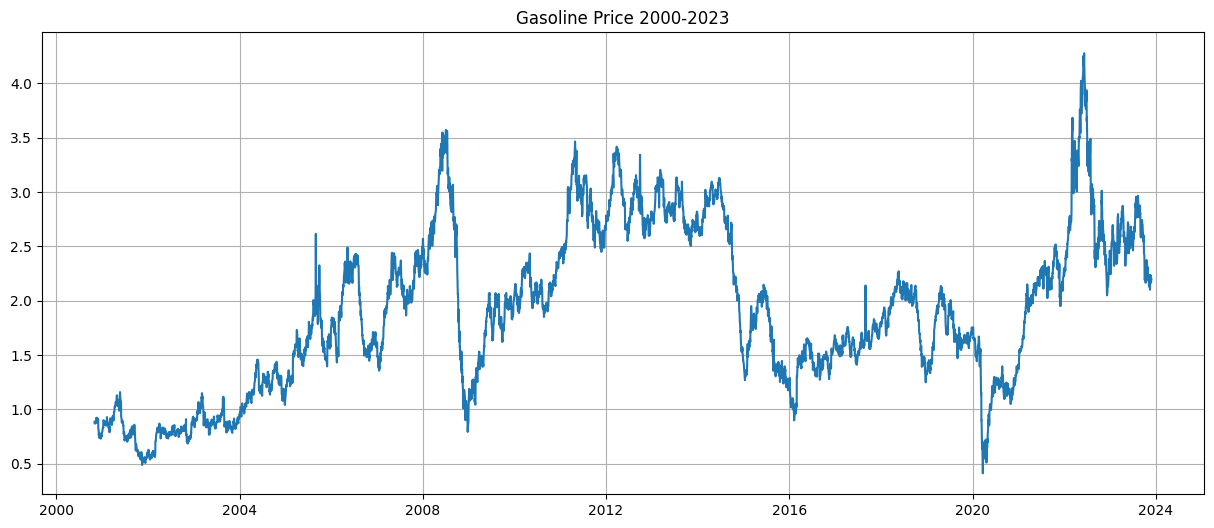

In [9]:
plt.figure(figsize=(15,6))
plt.plot(gasoline['date'], gasoline['close'])
plt.title('Gasoline Price 2000-2023')
plt.grid(True)
plt.show()

In [10]:
gasoline.describe()

,date,open,high,low,close,volume
count,5794,5794.000000,5794.000000,5794.000000,5794.000000,5794.000000
mean,2012-05-20 20:54:50.576458496,1.898424,1.927892,1.867614,1.899182,40115.351398
min,2000-11-01 00:00:00,0.427300,0.507500,0.376000,0.411800,0.000000
25%,2006-08-22 06:00:00,1.345525,1.369900,1.320025,1.347975,24229.750000
50%,2012-05-17 12:00:00,1.874650,1.903400,1.848200,1.877100,36319.000000
75%,2018-02-25 06:00:00,2.467575,2.504000,2.423475,2.462950,54043.500000
max,2023-11-27 00:00:00,4.272500,4.326000,4.184500,4.276200,190777.000000
std,NaN,0.737745,0.745839,0.728556,0.738199,21177.047423


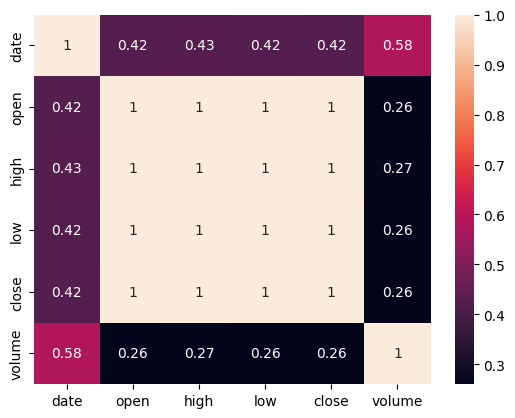

In [11]:
corr_mx = gasoline.corr()

sns.heatmap(corr_mx, annot=True)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x500 with 0 Axes>

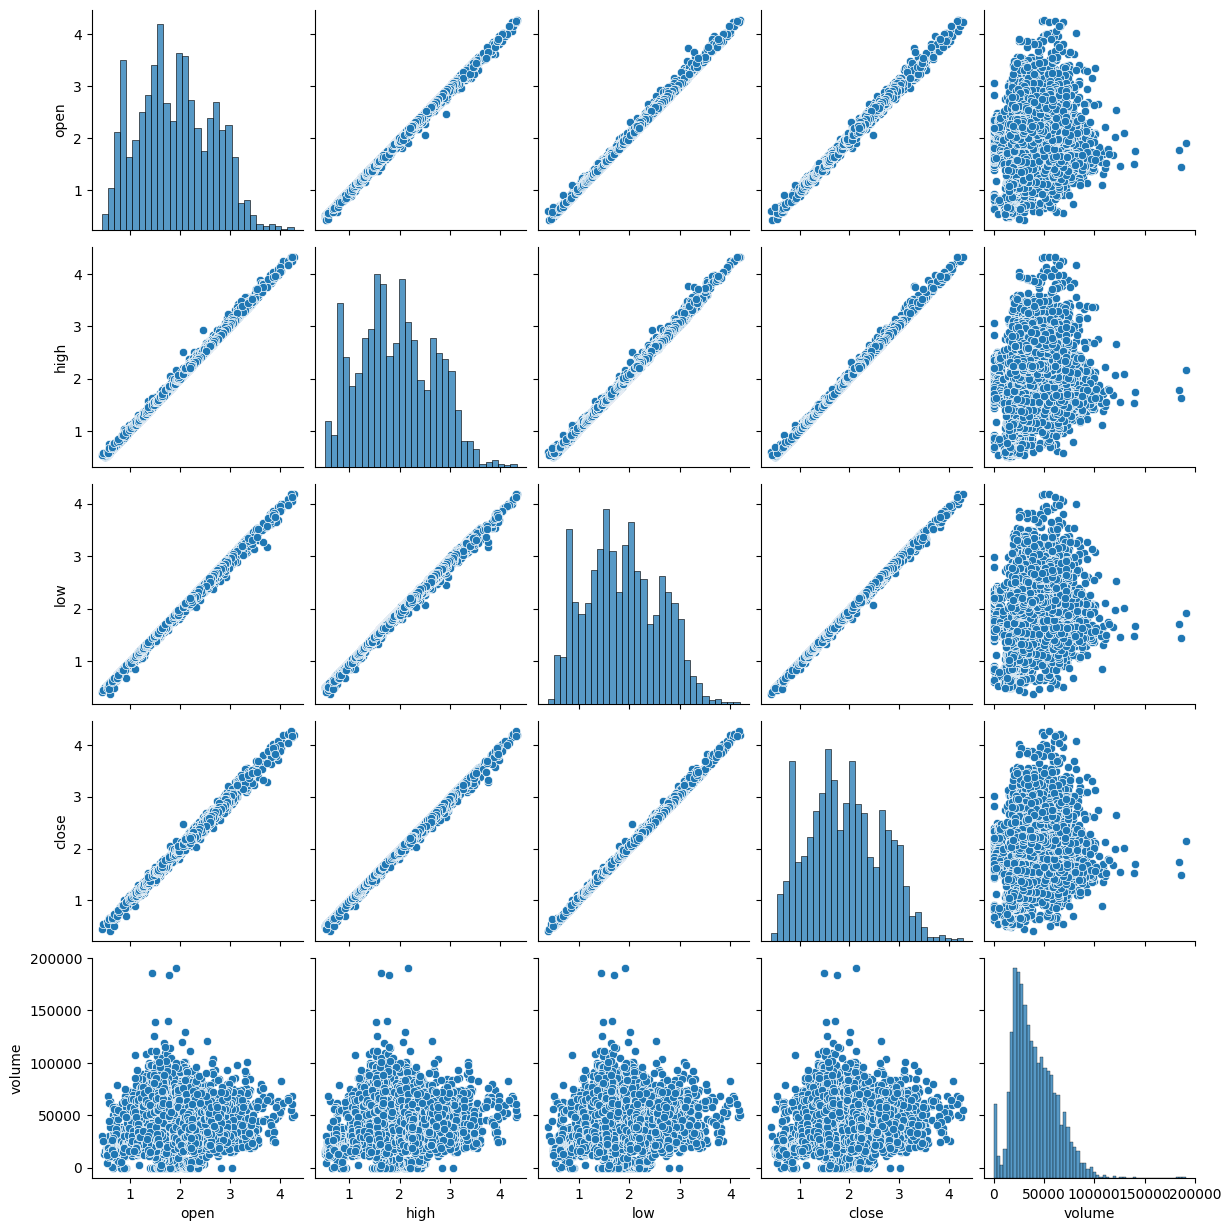

In [12]:
plt.figure(figsize=(15,5))
sns.pairplot(gasoline)
plt.show()

### Feature Creation

In [13]:
n = 50
alpha = 2 / (n + 1)

def create_features(gasoline):
    # Exponential Moving Average
    gasoline['EMA'] = gasoline['close'] \
                      .ewm(alpha=alpha, adjust=True).mean()
    return gasoline

gasoline = create_features(gasoline)

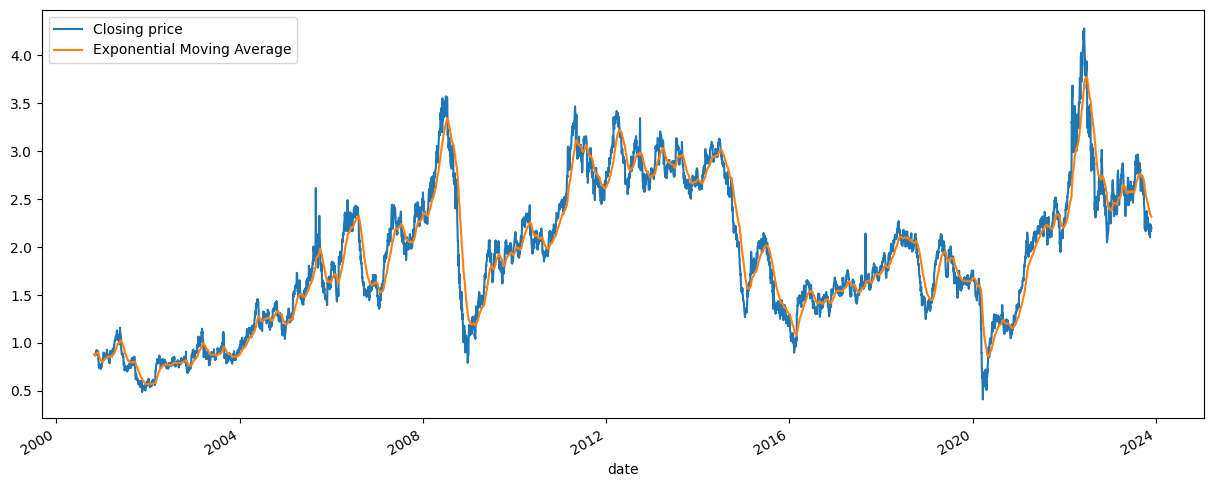

In [14]:
fx, ax = plt.subplots(figsize=(15,6))

gasoline.plot(ax=ax, x='date', y='close', label='Closing price')
gasoline.plot(ax=ax, x='date', y='EMA', label='Exponential Moving Average')
plt.show()

In [15]:
gasoline.head()

,date,open,high,low,close,volume,EMA
0,2000-11-01,0.8890,0.8970,0.882,0.8840,16223,0.884000
1,2000-11-02,0.8750,0.8876,0.863,0.8688,17216,0.876248
2,2000-11-03,0.8675,0.8750,0.860,0.8695,10170,0.873908
3,2000-11-06,0.8600,0.8850,0.856,0.8825,16184,0.876187
4,2000-11-07,0.8930,0.9000,0.886,0.8910,15717,0.879391


## Model Creation

In [16]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=365, gap=12)

### Timeseries Cross Validation

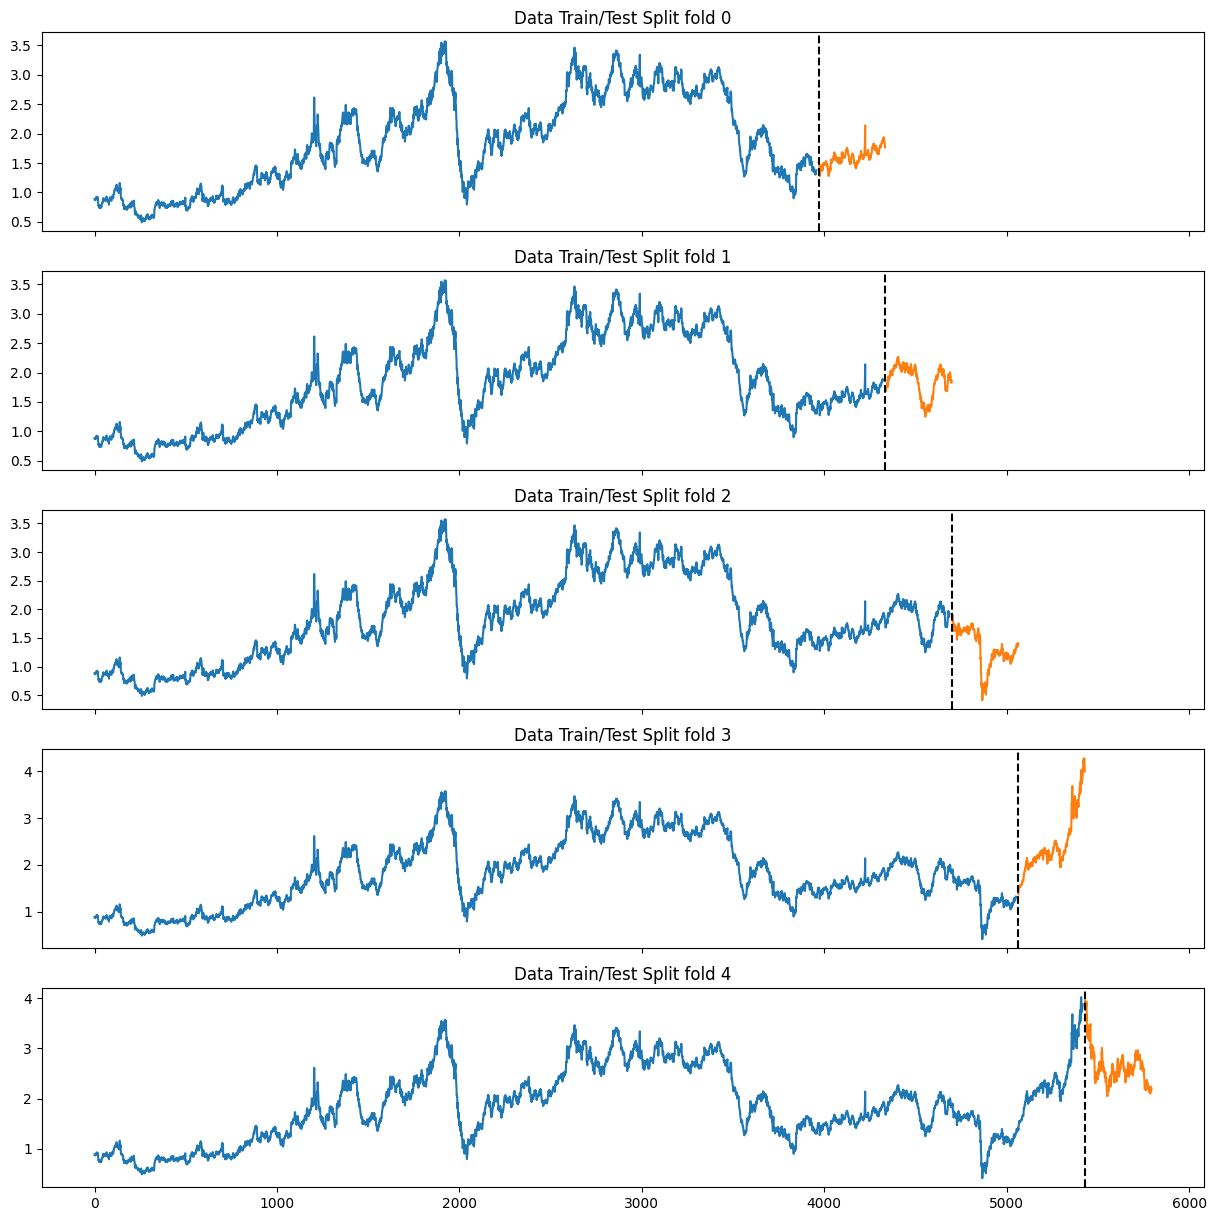

In [17]:
fx, axs = plt.subplots(5,1, figsize=(15,15), sharex=True)

fold = 0

for train_idx, val_idx in tss.split(gasoline):
    train = gasoline.iloc[train_idx]
    test = gasoline.iloc[val_idx]
    train['close'].plot(ax=axs[fold], label='Training set',
                           title=f'Data Train/Test Split fold {fold}')
    test['close'].plot(ax=axs[fold], label='Testing Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

plt.show()

In [18]:
reg = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01,
                       early_stopping_rounds=50)

fold = 0
pred = []
score = []

for train_idx, val_idx in tss.split(gasoline):
    train = gasoline.iloc[train_idx]
    test = gasoline.iloc[val_idx]
    
    FEATURES = ['open', 'high', 'low', 'EMA', 'volume']
    TARGET = ['close']
    
    X_train = train[FEATURES]
    Y_train = train[TARGET]
    
    x_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg.fit(X_train, Y_train,
            eval_set=[(X_train, Y_train), (x_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(x_test)
    pred.append(y_pred)
    scores = np.sqrt(mean_squared_error(y_test, y_pred))
    score.append(scores)

[0]	validation_0-rmse:1.55893	validation_1-rmse:1.10046
[100]	validation_0-rmse:0.57398	validation_1-rmse:0.40423
[200]	validation_0-rmse:0.21207	validation_1-rmse:0.14920
[300]	validation_0-rmse:0.07995	validation_1-rmse:0.05720
[400]	validation_0-rmse:0.03313	validation_1-rmse:0.02555
[500]	validation_0-rmse:0.01833	validation_1-rmse:0.01704
[600]	validation_0-rmse:0.01445	validation_1-rmse:0.01549
[700]	validation_0-rmse:0.01322	validation_1-rmse:0.01519
[800]	validation_0-rmse:0.01255	validation_1-rmse:0.01506
[866]	validation_0-rmse:0.01225	validation_1-rmse:0.01507
[0]	validation_0-rmse:1.52459	validation_1-rmse:1.38046
[100]	validation_0-rmse:0.56127	validation_1-rmse:0.50660
[200]	validation_0-rmse:0.20734	validation_1-rmse:0.18599
[300]	validation_0-rmse:0.07818	validation_1-rmse:0.07117
[400]	validation_0-rmse:0.03244	validation_1-rmse:0.03140
[500]	validation_0-rmse:0.01802	validation_1-rmse:0.01999
[600]	validation_0-rmse:0.01427	validation_1-rmse:0.01747
[700]	validation_0

In [19]:
print(f"Score = {np.mean(score):.4f}")

Score = 0.0450
